# Introduction
This is a take-home challenge from the Relax.Inc company. Data is given in CSV files: 'takehome_user_engagement.csv' and 'takehome_users.csv'. 

**Data**<br>
'takehome_users.csv' has data on 12,000 users who signed up for the product in the last two years. <br> 
'takehome_user_engagement' has a row for each day that a user logged into the product. <br>
Details about the data are given in 'relax_data_science_challenge.pdf'.


**Challenge**<br>
Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. The challenge is to identify which factors predict future user adoption.



# Load Data

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})


# Model learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
user=pd.read_csv('takehome_users.csv',encoding="latin1",parse_dates=True,infer_datetime_format=True)
user.info()
user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
usage=pd.read_csv('takehome_user_engagement.csv',encoding="utf-8",parse_dates=True,infer_datetime_format=True)
usage.info()
usage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Data Wrangling

## Adopted User

Since the aim is to identify which factors predict future user adoption. We first generate the target variable 'adopted_user',  defined as a user who has logged into the product on three separate days in at least one seven-day period. So we calculate the interval between the third and the first login for each user, which if no more than 6 days and no less than 2 days, that user is an adopted user.

In [4]:
# Number of users with login information
print('Number of login users: ',usage.user_id.nunique())

# Count the login times for each user
user_logintimes=usage.user_id.value_counts().sort_index()

# Rule out login times below 3
mask_above3=user_logintimes>=3
print('Number of users with login times>=3: ',mask_above3.sum())

Number of login users:  8823
Number of users with login times>=3:  2248


This number of users with login information is consistent with the number of non-null values in 'last_session_creation_time' feature of user table related with last login.

In [5]:
# Subset the usage table to include only users with login times above or equal to 3
id_above3=user_logintimes[mask_above3].index.tolist()
usage_sub=usage[usage.user_id.isin(id_above3)].set_index('user_id')
usage_sub.time_stamp=pd.to_datetime(usage_sub.time_stamp)


# Calculate the differece in days for every other login. If there is at least once that the day-difference 
#between the first and third login is in 6 days...2 days, the corresponding user is an adopted user.
diff_days=usage_sub.groupby('user_id')['time_stamp'].diff(periods=2)
id_adopted=diff_days[diff_days.isin([ str(i)+ ' days' for i in range(2,7)])].index.unique().tolist()

In [6]:
# Add the 'adopted_user' feature in user data
user['adopted_user']=np.where(user.object_id.isin(id_adopted), 1,0)
user.set_index('object_id',inplace=True)

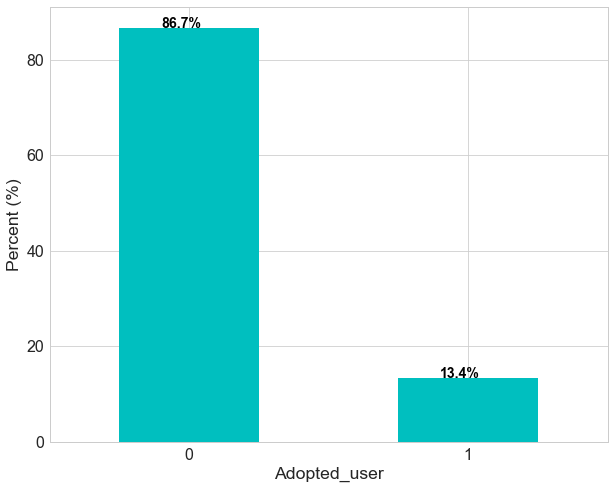

In [7]:
def plot_bar(s,xlab,rot=0):
    '''customized barplot with the height of bar represening share (in percentage) of that feature'''
    ax=s.plot(kind='bar',rot=rot,color='c',figsize=(10,8))
    for i, v in enumerate(s):
        ax.text( i-0.1,v , str(round(v,1))+'%', color='black', fontweight='bold',fontsize=14)
    plt.xlabel(xlab)
    plt.ylabel('Percent (%)');
    

adopt_user_per=user.adopted_user.value_counts(normalize=True)*100

plot_bar(adopt_user_per,'Adopted_user',0)




Most of users (87%) are not adopted users and only 13% are adopted users.

## Data Cleaning
We perform data cleaning in the following steps:
1. Check and remove duplicates
2. Check and handle missing values
3. Clean relevant features

In [8]:
# Check duplicates
print('Number of duplicates: ', user.duplicated().sum())
print('Missing values: ')
# Check missing values
user.isnull().sum()

Number of duplicates:  0
Missing values: 


creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

**Summary**<br>
There in no duplicated observation.<br>
Feature 'last_session_creation_time' and 'invited_by_user_id' have missing values.<br>
As a summary, we will work on those features:<br>

1. 'email':
Which emails users use might be related with login behavior of users. So we simplify the email feature by extracting the host name, i.e., 'gmail', 'yahoo'... 

2. 'creation_source':
This feature will be converted to categorical features.

3. 'last_session_creation_time':
We will convert into date time type and fill missing values with creation-time.

4. 'invited_by_user_id':
This feature might affect whether a user will be an adopted user or not. Since the exact user_id who invites might not be important, we will convert it into a categorical variable depending on whether or not invited by users.

5. 'org_id':.
We will convert it into categorical feature.

**1. Extract email domains**<br>
We will extract domain from email address and convert it to categorical features.

In [9]:
user.email=user.email.str.split('@',expand=True)[1]
user.email.value_counts().head(10)

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xvnbr.com            2
xybhi.com            2
qgjbc.com            2
oqpze.com            2
Name: email, dtype: int64

We only keep those emails with domains that occured more than twice and put remaining emails as 'other'.

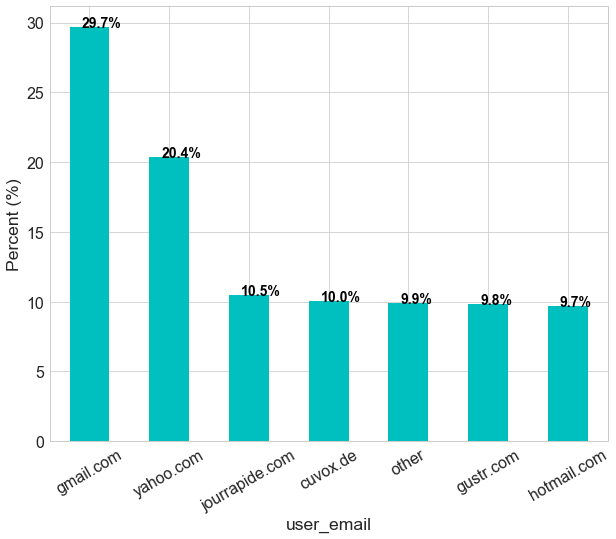

In [10]:
email_keep=user.email.value_counts()[user.email.value_counts()>2].index.tolist()
user.email=user.email.apply(lambda x: x if x in email_keep else 'other').astype('category')
plot_bar(user.email.value_counts(normalize=True)*100,'user_email',30)

**2. Creation_source**

In [11]:
user.creation_source=user.creation_source.astype('category')
#plot_bar(user.creation_source.value_counts(normalize=True)*100,'creation_source',30)

**3. Fix last_session_creation_time**

In [12]:
#convert seconds to datetime
user.last_session_creation_time=pd.to_datetime(user.last_session_creation_time,unit='s')
#find users with no logins
id_nologin=user.index[pd.to_datetime(user.last_session_creation_time,unit='s').isnull()].tolist()

#fill missing values with creation_time
user.last_session_creation_time=[user.last_session_creation_time[i] if i not in id_nologin else user.creation_time[i] for i in range(1,len(user)+1)]


**4. Binarize invited_by_user_id**

In [13]:
user.invited_by_user_id=np.where(user.invited_by_user_id>0,1,0)

**5. Convert org_id ** 

In [14]:
print( 'Number of unique organizations:', user.org_id.nunique())
user.org_id=user.org_id.astype('category')
user.org_id.value_counts().head(10)

Number of unique organizations: 417


0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
Name: org_id, dtype: int64

## Summary Statistics

In [15]:
user.info()
user.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null category
creation_source               12000 non-null category
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null category
invited_by_user_id            12000 non-null int64
adopted_user                  12000 non-null int64
dtypes: category(3), datetime64[ns](1), int64(4), object(2)
memory usage: 1.1+ MB


,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0
2,2013-11-15 03:45:04,Poole Matthew,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1
3,2013-03-19 23:14:52,Bottrill Mitchell,gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0
4,2013-05-21 08:09:28,Clausen Nicklas,yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0
5,2013-01-17 10:14:20,Raw Grace,yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0


In [16]:
user.select_dtypes(exclude='int').describe()

,creation_time,name,email,creation_source,last_session_creation_time,org_id
count,12000,12000,12000,12000,12000,12000.0
unique,11996,11355,7,5,11998,417.0
top,2012-09-01 07:22:09,Araujo Gabriela,gmail.com,ORG_INVITE,2014-06-04 07:46:58,0.0
freq,2,5,3562,4254,2,319.0
first,NaN,NaN,NaN,NaN,2012-05-31 08:20:06,NaN
last,NaN,NaN,NaN,NaN,2014-06-06 14:58:50,NaN


# Build Machine Learning Models

In [17]:
#Select features by dropping some irrelevant ones 
cols=user.columns.drop(['creation_time', 'name','last_session_creation_time','adopted_user']).tolist()
cols

['email',
 'creation_source',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'org_id',
 'invited_by_user_id']

In [18]:
# Perform one-hot encoding on categorical features and build X and y for feeding into classifier
X = pd.get_dummies(user[cols], columns=['email','creation_source','org_id'], drop_first=True)
y = user.adopted_user

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=100)


RF= RandomForestClassifier( )
RF.fit(X, y)
y_pred=RF.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test,y_pred)*100)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Report :\n", classification_report(y_test,y_pred))



/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy :  93.16666666666666
Confusion Matrix:
 [[3059   59]
 [ 187  295]]
Report :
              precision    recall  f1-score   support

          0       0.94      0.98      0.96      3118
          1       0.83      0.61      0.71       482

avg / total       0.93      0.93      0.93      3600



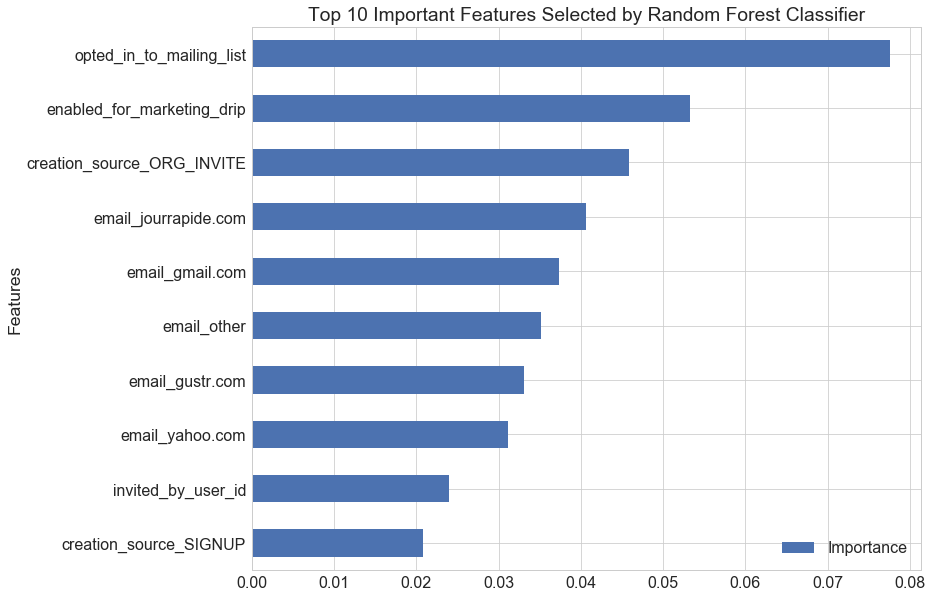

In [19]:
features=X.columns.values.tolist()
df=pd.DataFrame({'Features': features, 'Importance': RF.feature_importances_}).sort_values('Importance',ascending=True).set_index('Features')
df[-10:].plot(kind='barh',figsize=(12,10))
plt.title('Top 10 Important Features Selected by Random Forest Classifier');

# Conclusions

According to the barplot of feature importance, top predictors are the following:
* 'opted_in_to_mailing_list', whether or not user opted into receiving marketing emails.  
* 'enabled_for_marketing_drip', whether they are on the regular marketing email drip
* 'creation_source', how their account was created, i.e., invited to an organization (as a full member) or signing up via the website
* users' emails addresses 
* whether they are invited by users